S1100: primary road <br>
S1200: secondary road <br>
S1400: a local neighborhood road, rural road, or city street <br>
Datum: Global Coordinate System North American Datum of 1983 (GCS NAD83) <br>

In [1]:
import geopandas as gpd
import matplotlib.axes
from shapely.geometry import LineString
import requests
import io
import zipfile
import os
from bs4 import BeautifulSoup
import pandas as pd

### Draft (please skip this part)

In [86]:
shapefile = gpd.read_file('./tl_2017_01001_roads/tl_2017_01001_roads.shp')
print(shapefile[0:5])

        LINEARID           FULLNAME RTTYP  MTFCC  \
0  1103672784948       McGee Rd Exn     M  S1400   
1  1103677525952       Buena Vis Lp     M  S1400   
2   110585079164         Co Rd 21 N     C  S1400   
3   110585079123         Co Rd 19 N     C  S1400   
4  1102603649960  Forest Ridge Rd N     M  S1400   

                                            geometry  
0  LINESTRING (-86.68571 32.604238, -86.685721 32...  
1  LINESTRING (-86.44949299999999 32.425500999999...  
2  LINESTRING (-86.63291199999999 32.437122999999...  
3  LINESTRING (-86.65293299999999 32.433411, -86....  
4  LINESTRING (-86.58537099999998 32.497436999999...  


In [87]:
type(shapefile)

geopandas.geodataframe.GeoDataFrame

In [88]:
print(shapefile.MTFCC[shapefile.MTFCC == 'S1100'])

165    S1100
502    S1100
Name: MTFCC, dtype: object


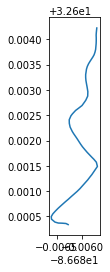

In [90]:
shapefile.loc[[0],'geometry'].plot()

In [91]:
sum(shapefile.geometry.length)

29.481480687949407

In [92]:
print(sum(shapefile[shapefile.MTFCC == 'S1100'].geometry.length))
print(sum(shapefile[shapefile.MTFCC == 'S1200'].geometry.length))
print(sum(shapefile[shapefile.MTFCC == 'S1400'].geometry.length))

0.4931948681252485
3.051733346792688
25.80323389622992


In [ ]:
def get_zip(file_url):
    url = requests.get(file_url)
    zip_file = zipfile.ZipFile(io.BytesIO(url.content))
    zip_names = zip_file.namelist()
#     if len(zip_names) == 1:
#         file_name = zip_names.pop()
#         extracted_file = zip_file.open(file_name)
#         return extracted_file
    return [zip_file.open(file_name) for file_name in zip_names]

filename = get_zip('https://www2.census.gov/geo/tiger/TIGER2017/ROADS/tl_2017_01001_roads.zip')

#### Debug

In [ ]:
url = requests.get('https://www2.census.gov/geo/tiger/TIGER2017/ROADS/tl_2017_12091_roads.zip')
zip_file = zipfile.ZipFile(io.BytesIO(url.content))
zip_names = zip_file.namelist()
print(zip_names)

In [ ]:
zip_file.open(zip_names[3])
# archive = zipfile.ZipFile(zip_file, 'r')
# shpfile = archive.open(zip_names[3])

.shp, .dbf and .shx have to be extracted together (https://gis.stackexchange.com/questions/262505/python-cant-read-shapefile)

In [ ]:
shp = zip_file.extract(zip_names[3])
dbf = zip_file.extract(zip_names[1])
shx = zip_file.extract(zip_names[-1])
print(shp, dbf, shx)

In [ ]:
shapefile_trial = gpd.read_file(shp)

In [ ]:
sum(shapefile_trial.geometry.length)

### Start from here

#### Scrape links of all zipfiles:

In [2]:
# Getting the webpage, creating a Response object.
response = requests.get('https://www2.census.gov/geo/tiger/TIGER2017/ROADS/')
 
# Extracting the source code of the page.
data = response.text
 
# Passing the source code to BeautifulSoup to create a BeautifulSoup object for it.
soup = BeautifulSoup(data, 'lxml')
 
# Find all the links on the page that end in .zip
extension = '.zip'

zip_links = []

for anchor in soup.findAll('a', href = True):
    links = 'https://www2.census.gov/geo/tiger/TIGER2017/ROADS/' + anchor['href']
    if links.endswith(extension):
        zip_links.append(links)

In [22]:
zip_links[0:5]

['https://www2.census.gov/geo/tiger/TIGER2017/ROADS/tl_2017_01001_roads.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/ROADS/tl_2017_01003_roads.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/ROADS/tl_2017_01005_roads.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/ROADS/tl_2017_01007_roads.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/ROADS/tl_2017_01009_roads.zip']

#### Function to sum the length:

In [4]:
def get_length(file_url):
    url = requests.get(file_url)  # Read the zipfile link
    zip_file = zipfile.ZipFile(io.BytesIO(url.content))
    zip_names = zip_file.namelist()  # Get names of all the files in the folder
    
    shp = zip_file.extract(zip_names[3])  # .shp, .dbf and .shx must be downloaded together to the local disk
    dbf = zip_file.extract(zip_names[1])
    shx = zip_file.extract(zip_names[-1])
    
    shapefile = gpd.read_file(shp)  # Read the shapefile
    
    code = zip_names[3][-15:-10]  # Get the county code
    len_tot = sum(shapefile.geometry.length)  # Sum the total length
    len_1 = sum(shapefile[shapefile.MTFCC == 'S1100'].geometry.length)  # Sum the length of primary roads
    len_2 = sum(shapefile[shapefile.MTFCC == 'S1200'].geometry.length)  # Sum the length of secondary roads
    len_3 = sum(shapefile[shapefile.MTFCC == 'S1400'].geometry.length)  # Sum the length of tertiary/local roads
    
    try:
        os.remove(shp)  # Remove the downloaded files (I didn't count but they probably would take 3-4 GB)
        os.remove(dbf)
        os.remove(shx)
    except OSError as e:
        print ('Error: %s - %s.' % (e.filename, e.strerror))
    
    return code, len_tot, len_1, len_2, len_3

In [5]:
result_list = [[None for _ in range(5)] for _ in range(len(zip_links))]  # Create a 3231*5 list to store the results

In [6]:
for i in range(0, len(zip_links)):
    code, len_tot, len_1, len_2, len_3 = get_length(zip_links[i])
    result_list[i] = [code, len_tot, len_1, len_2, len_3]

#### Runtime:<br>
03:03-03:53 (50 min; must keep the laptop awake all the way)

In [23]:
result_list[0:5]

[['01001',
  29.481480687949407,
  0.4931948681252485,
  3.051733346792688,
  25.80323389622992],
 ['01003',
  85.46564088381582,
  1.9705231320043772,
  12.521230842050938,
  68.00415074948309],
 ['01005', 27.441135839543453, 0, 6.120281817796836, 20.427702698511336],
 ['01007', 28.753979704795853, 0, 4.346076830242731, 23.16849169063316],
 ['01009',
  33.80040434943042,
  0.3631884705325289,
  4.515437808230292,
  26.625752304433384]]

In [8]:
# Create dataframe
result_df = pd.DataFrame(result_list, columns=['County_code', 'Total_length',
                                               'Primary_length', 'Secondary_length', 'Local_length'])

In [18]:
result_df.head()

,County_code,Total_length,Primary_length,Secondary_length,Local_length
0,01001,29.481481,0.493195,3.051733,25.803234
1,01003,85.465641,1.970523,12.521231,68.004151
2,01005,27.441136,0.000000,6.120282,20.427703
3,01007,28.753980,0.000000,4.346077,23.168492
4,01009,33.800404,0.363188,4.515438,26.625752


#### Write to csv:

With index

In [13]:
result_df.to_csv('Road_length_index.csv')

Without index

In [11]:
result_df.to_csv('Road_length.csv', index = False)

#### Read csv (remember to specify county code data type to avoid losing the leading zeros):

In [20]:
result_read = pd.read_csv('Road_length.csv', dtype = {'County_code': object})

In [21]:
result_read.head()

,County_code,Total_length,Primary_length,Secondary_length,Local_length
0,01001,29.481481,0.493195,3.051733,25.803234
1,01003,85.465641,1.970523,12.521231,68.004151
2,01005,27.441136,0.000000,6.120282,20.427703
3,01007,28.753980,0.000000,4.346077,23.168492
4,01009,33.800404,0.363188,4.515438,26.625752


#### Read county code text file: <br>
Scraped (= copied & pasted) from source: <br>
County FIPS Codes: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

In [37]:
code_df = pd.read_csv('County_code.txt', engine = 'python', sep = '\t', header = 0, dtype = {'FIPS': object})

code_df.rename(columns = {'FIPS': 'County_code'}, inplace = True)  # Rename column for later joining dataframes

In [38]:
code_df.head()

,County_code,Name,State
0,01001,Autauga,AL
1,01003,Baldwin,AL
2,01005,Barbour,AL
3,01007,Bibb,AL
4,01009,Blount,AL


#### Join length and county information (key = county code):

In [113]:
length_code_df = result_read.join(code_df.set_index('County_code'), on = 'County_code')

In [114]:
length_code_df.head()

,County_code,Total_length,Primary_length,Secondary_length,Local_length,Name,State
0,01001,29.481481,0.493195,3.051733,25.803234,Autauga,AL
1,01003,85.465641,1.970523,12.521231,68.004151,Baldwin,AL
2,01005,27.441136,0.000000,6.120282,20.427703,Barbour,AL
3,01007,28.753980,0.000000,4.346077,23.168492,Bibb,AL
4,01009,33.800404,0.363188,4.515438,26.625752,Blount,AL


In [115]:
print(len(result_read))
print(len(code_df))
print(len(length_code_df))

3231
3232
3235


Tricky thing: there are 3231 records of shapefiles, 3232 of county code, but 3235 rows after joining the two tables.

In [116]:
print(length_code_df.loc[pd.isna(length_code_df['Name']), :].index)

Int64Index([76, 81, 87, 88, 90, 93, 251, 362, 548, 2412, 3144, 3169, 3185], dtype='int64')


In [117]:
length_code_df.iloc[76, :]

County_code            02105
Total_length         7.29188
Primary_length             0
Secondary_length    0.133991
Local_length         5.62058
Name                     NaN
State                    NaN
Name: 76, dtype: object

Above shows a case of shapefile-derived fields having valid numbers while county info not found. <br>
If we join county code with shapefile results (c.f. shapefile results joined with county code), out of the total 3232 rows, there will be 10 rows with shapefile results missing (shown below).

In [48]:
# print(length_code_df.loc[pd.isna(length_code_df['Total_length']), :].index)

Int64Index([85, 87, 90, 91, 329, 1650, 2414, 2913, 2918, 2946], dtype='int64')


13 cnty code w/o names, 3222 w/ all fields not nan, 10 w/o shapefiles, what does this imply? <br>
3222 exact matches, 10 in cnty code df but not in TIGER (has county info but no shapefiles), 13 in TIGER but not in cnty code df (has shapefiles but no county info). <br>
It turned out that some FIPS codes are shared by more than one county, if not caused by the unreliable data source or my ignorance (hopefully not..). <br>
These codes are 60020 (row 3143-3145; shared by three counties), 69120 (row 3152-3153; shared by two), 66010 (row 3148-3149; shared by two).

In [118]:
length_code_df['County_code'].value_counts().head()

60020    3
69120    2
66010    2
28059    1
27025    1
Name: County_code, dtype: int64

In details:

In [167]:
print(length_code_df.index[length_code_df['County_code'] == '66010' ])
print(length_code_df.index[length_code_df['County_code'] == '60020' ])
print(length_code_df.index[length_code_df['County_code'] == '69120' ])

Int64Index([3146, 3146], dtype='int64')
Int64Index([3143, 3143, 3143], dtype='int64')
Int64Index([3149, 3149], dtype='int64')


In [168]:
length_code_df.iloc[3148:3150, :]

,County_code,Name,State,Total_length,Primary_length,Secondary_length,Local_length
3146,66010,Cocos Island,MP,21.667835,0.0,4.216978,15.985018
3146,66010,Guam,GU,21.667835,0.0,4.216978,15.985018


In [169]:
length_code_df.iloc[3143:3146, :]

,County_code,Name,State,Total_length,Primary_length,Secondary_length,Local_length
3143,60020,Manua,AS,0.417914,0.0,0.085862,0.289747
3143,60020,Ofu,AS,0.417914,0.0,0.085862,0.289747
3143,60020,Olosega,AS,0.417914,0.0,0.085862,0.289747


In [170]:
length_code_df.iloc[3152:3154, :]

,County_code,Name,State,Total_length,Primary_length,Secondary_length,Local_length
3149,69120,Aguijan,MP,1.860377,0.0,0.0,1.820647
3149,69120,Tinian,MP,1.860377,0.0,0.0,1.820647


I chose to keep all rows associated with the double/triple counting FIPS codes. The road lengths (total, primary, secondary, tertiary) are the lengths in all the regions using that specific code. <br> These "duplicated" rows could be removed if needed.

In [122]:
# Change the order of dataframe columns so it looks better
length_code_df = length_code_df[['County_code', 'Name', 'State', 'Total_length',
                                 'Primary_length', 'Secondary_length', 'Local_length']]

#### Sum road lengths for each state:

In [133]:
# Remove duplicated rows
length_code_drop = length_code_df.drop_duplicates(subset = 'County_code', keep = False, inplace = False)

# Remove fields County_code and Name
length_code_drop.drop(['County_code', 'Name'], axis = 1, inplace = True)

# Group by State and sum road lengths
length_state_df = length_code_drop.groupby(['State']).sum()

length_state_df.head()

,Total_length,Primary_length,Secondary_length,Local_length
State,,,,
AK,895.233093,0.000000,132.838202,341.759584
AL,2664.808526,36.268401,364.708086,2125.740596
AR,2673.007555,33.377168,372.063020,2082.519079
AS,3.516936,0.000000,1.224505,2.014096
AZ,3225.156975,50.765057,146.140749,2718.015609


I try to anually resolve the rows without matching FIPS code: <br>
Unmatched county codes: 02105, 02158, 02195, 02198, 02230, 02275, 08014, 12086, 15005, 46102, 60040, 72039, 72069. <br>
Only 02198 can be found here (https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html/all-geocodes-v2017.xlsx) - state code "36" (New York) area name "Angola Village".

In [152]:
length_code_df[pd.isna(length_code_df['Name'])]

,County_code,Name,State,Total_length,Primary_length,Secondary_length,Local_length
76,02105,NaN,NaN,7.291885,0.000000,0.133991,5.620579
81,02158,NaN,NaN,8.919340,0.000000,0.000000,2.243305
87,02195,NaN,NaN,7.293124,0.000000,0.599208,4.404794
88,02198,NaN,NaN,19.046486,0.000000,1.368866,14.739086
90,02230,NaN,NaN,1.753407,0.000000,0.478176,0.717040
93,02275,NaN,NaN,2.896570,0.000000,0.000000,1.968931
251,08014,NaN,NaN,8.344418,0.196412,1.456495,5.694466
362,12086,NaN,NaN,153.482696,1.433934,20.223056,126.183320
548,15005,NaN,NaN,0.318191,0.000000,0.000000,0.150673
2412,46102,NaN,NaN,42.997933,0.000000,1.110654,30.250262


In [164]:
# Adding county code 02198

length_state_df.loc['NY'] = length_code_df.iloc[88, [3, 4, 5, 6]] + length_state_df.loc['NY']

Since none of the "shared county code" areas (which are in American Samoa, Northern Mariana Islands and Guam) are in the 50 states, those respective records are not considered. And the exsiting rows of the insular areas are to be removed:

In [174]:
length_state_df.drop(['AS', 'IA', 'MP', 'PR', 'VI'], inplace = True)

In [176]:
len(length_state_df)  # 50 states

50

#### Write to csv:

In [93]:
length_code_df.to_csv('Road_comb_county.csv', index = False)

In [177]:
length_state_df.to_csv('Road_comb_state.csv', index = True)

In [181]:
# Save the unmatched records

unmatched_df = length_code_df[pd.isna(length_code_df['Name'])]
unmatched_df.drop([88], inplace = True)

unmatched_df.to_csv('Road_unmatched.csv', index = False)